# End-to-end DSPy Workflows Guide 

# TODO: Motivation - have this problem and going to solve it with dspy and that is why we believe ti is the right solution

This guide will cover the following topics:

## Creating a Multi-stage LLM Pipeline
- Building a pipeline with an untuned model in DSPy
- Implementing batch inference (using Ray data)

## Improving the Pipeline
1. Prompt optimization
2. Fine-tuning
    - How to make an 8B model perform almost as well as a 70B model in your pipeline
3. Combining fine-tuning with prompt optimization

## Deployment
- Steps to deploy the optimized pipeline and fine-tuned model to production

## Future Work and Open Questions
- Efficient batch inference with a DSPy pipeline
- Exploring different fine-tuning methods and hyperparameter sweeps

This guide aims to provide a comprehensive overview of building, optimizing, and deploying LLM pipelines using DSPy and Anyscale.

## Set up

Node Set up:

We will be running everything on a head node that uses 4xA100-80GB GPUs. I find that L4s are usually available and suitable for this usecase. You can also use any more powerful node.

To change to use A100 GPUs, click the "1 active node" in the top right corner, then for workspace node, click the pencil icon and navigate to the A100 tab and select the 4xA100 option. If you do not see A100 in the list of GPUs, they may not be available on your cloud. Choose another kind of GPU (This notebook has been tested on X, and Y as alternatives) (TODO)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO(work): DSPy installation cell
# TODO(decision): are these changes going to be merged into DSPy main

# TODO: look at my own init file to see all the stupid extra pip installs

# !pip install -e dspy-d
# !pip install -r dspy-d/requirements.txt
# !pip install vllm

# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import dspy
import dsp
import os
import ujson

from dotenv import load_dotenv
# TODO: include cache in notebook
cache_dir = "/home/ray/default/dspy/cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
# I have included a .env.example with the necessary environment variables to be set
# You can also set them manually if you prefer

os.environ["DSP_CACHEDIR"] = cache_dir

load_dotenv()

True

In [4]:
necessary_env_vars = [
    "DSP_CACHEDIR",
    "HF_TOKEN",
    "HF_HOME"
]

for var in necessary_env_vars:
    assert os.environ[var], f"{var} is not set"

In [5]:
import ray

if not ray.is_initialized():
    ray.init(runtime_env={"env_vars": os.environ, "py_modules": [dspy, dsp]})

2024-10-07 23:47:29,464	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.15.218:6379...
2024-10-07 23:47:29,473	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-07 23:47:29,499	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dspy'.
2024-10-07 23:47:29,531	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_6743b1324906ffbb.zip' (0.89MiB) to Ray cluster...
2024-10-07 23:47:29,541	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_6743b1324906ffbb.zip'.
2024-10-07 23:47:29,554	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dsp'.
2024-10-07 23:47:29,576	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_bb60ed915e68a449.zip' (0.64MiB) to Ray cluster...
2024-10-07 23:47:29,579	INFO packaging.py:372 -- Successfully pushed file package 'g

We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [6]:
import random

rng = random.Random()

# Creating your multi-stage LLM pipeline

In [7]:
from dspy.datasets import HotPotQA
from dspy.evaluate import Evaluate
from dsp.utils.utils import deduplicate


# We are setting the experimental flag to True to make use of the fine-tuning
# features that are still in development.
dspy.settings.configure(experimental=True)

class IntentExtraction(dspy.Signature):
    """Extract the intent of a natural language query."""

    text = dspy.InputField(desc="Natural language query")
    intent = dspy.OutputField(desc="Intent of the query")

class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")


class UnifiedIntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
    """

    text = dspy.InputField(desc="Natural language query")
    description = dspy.OutputField(desc="Description of the intent; Should be 4-5 words of what the user wants")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

class SimpleIntentClassificationModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)

        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"))
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction



# Let's break down the Text to SQL program

Below we load the dataset using a built in `HotPotQA` dataset class from DSPy.

We set the `train_seed` and `eval_seed` to `0` for reproducibility and the `test_size` to `0` because we do not need a test set for this tutorial.

In [8]:
# Prepare the dataset
from dspy.datasets import DataLoader

dl = DataLoader()
full_trainset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="train"
)

full_testset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="test"
)

# Find the 15 most common class labels
from collections import Counter

# Count occurrences of each label
label_counts = Counter(example['label'] for example in full_trainset)
print(label_counts)

# Get the 15 most common labels
top_25_labels = set([label for label, _ in label_counts.most_common(25)])

# Filter the datasets to only include examples with the top 15 labels
full_trainset_filtered = [example for example in full_trainset if example['label'] in top_25_labels]
full_testset_filtered = [example for example in full_testset if example['label'] in top_25_labels]

# Replace the original datasets with the filtered versions
full_trainset = full_trainset_filtered
full_testset = full_testset_filtered

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set: {len(full_trainset)}")
print(f"Test set: {len(full_testset)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")


TRAIN_SIZE = 2000
DEV_SIZE = 1500
trainset = full_trainset[:TRAIN_SIZE]
devset = full_trainset[TRAIN_SIZE:TRAIN_SIZE+DEV_SIZE]
testset = full_testset

Counter({15: 187, 28: 182, 6: 181, 75: 180, 19: 177, 63: 175, 26: 173, 64: 172, 66: 171, 5: 171, 52: 169, 16: 168, 17: 167, 34: 166, 76: 163, 51: 162, 53: 161, 20: 160, 45: 159, 0: 159, 8: 157, 7: 156, 11: 153, 25: 153, 47: 149, 48: 148, 61: 146, 59: 145, 46: 143, 13: 139, 35: 137, 73: 135, 27: 133, 54: 129, 39: 129, 9: 129, 24: 129, 67: 128, 4: 127, 36: 126, 71: 126, 2: 126, 21: 122, 30: 121, 74: 121, 29: 121, 42: 121, 31: 121, 43: 120, 33: 118, 49: 115, 58: 114, 57: 114, 70: 113, 65: 113, 32: 112, 12: 112, 14: 112, 56: 111, 1: 110, 55: 108, 38: 106, 44: 105, 69: 104, 62: 103, 68: 102, 40: 98, 60: 97, 37: 97, 50: 95, 3: 87, 22: 86, 41: 82, 18: 61, 10: 59, 72: 41, 23: 35})
Dataset filtered to top 25 labels. New sizes:
Training set: 4171
Test set: 1000
Top 25 labels: 0, 5, 6, 7, 8, 11, 15, 16, 17, 19, 20, 25, 26, 28, 34, 45, 47, 51, 52, 53, 63, 64, 66, 75, 76


In [9]:
int_to_label_dict = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "Refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal"
}

label_to_int_dict = {v: k for k, v in int_to_label_dict.items()}


In [10]:
labels_in_use = [int_to_label_dict[label] for label in top_25_labels]

print(labels_in_use)

def convert_int_to_label(example):
    example["label"] = int_to_label_dict[example["label"]]
    return example

trainset = [convert_int_to_label(example) for example in trainset]
devset = [convert_int_to_label(example) for example in devset]
testset = [convert_int_to_label(example) for example in testset]

print(trainset[0])

['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})


Here we set up the metric and evaluator. We will be using the answer exact match metric.

The evaluator is what we will consider as our test set.

We choose `num_threads=90` because we are bottlenecked by the retrieval server, and through testing this is the maximum number of concurrent threads that can be run without causing issues for other people using the retrieval server.

In [11]:
# Prepare the metric and evaluator
NUM_THREADS = 250
def answer_exact_match(example, pred, trace=None, frac=1.0):
    try:
        example.answer = example.label
        pred.answer = pred.label
        if type(example.answer) is str:
            return dsp.answer_match(pred.answer, [example.answer], frac=frac)
        else: # type(example.answer) is list
            return dsp.answer_match(pred.answer, example.answer, frac=frac)
    except Exception as e:
        print(f"Error in answer_exact_match: {e}")
        print(f"Example: {example}")
        print(f"Prediction: {pred}")
        return False

metric = answer_exact_match

evaluation_devset = devset.copy()
rng.shuffle(evaluation_devset)
evaluate_devset = Evaluate(devset=evaluation_devset[:DEV_SIZE], metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)


TODO(optional): Implement LLM as judge

## Gathering baseline performance

run evaluate on a base pipeline

In [12]:
MAX_TOKENS = 1000
MODEL_PARAMETERS = {
  "max_tokens": MAX_TOKENS,
  "temperature": 0,
}

LOCAL_API_PARAMETERS = {
  "api_base": "http://localhost:8000/v1",
  "api_key": "fake-key-doesnt-matter"
}
vanilla_program = SimpleIntentClassificationModule()

In [ ]:
# Note: Run above this to do all setup without launching any models

We will be using a local VLLM instance to run the initial benchmarks and data collection.

The first model to run is the 8B model in order to collect a baseline of performance.

You can run the local VLLM instance with the following command:

Make sure to set your HF_TOKEN and HF_HOME environment variables

For Anyscale, putting models into /mnt/local_storage is a typical pattern.


`vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`

Lets break down what this command does:
- `vllm serve` is the command to run the VLLM server
- `meta-llama/Meta-Llama-3.1-8B-Instruct` is the model to run
- `--port 8000` is the port to run the server on
- `--pipeline_parallel_size 4` is the number of pipeline parallel size to run the server with. We are using 4 because we have 4 GPUs all of which can hold an instance of the model.
- `--enable_prefix_caching` is the flag to enable the prefix caching. This will store and reuse the beginnings of prompts to avoid repeating the same computation. This is especially useful for DSPy since we are almost always using prompts with the same beginning parts in the form of few shot demonstrations.

In [ ]:
# Command for easy copying: 
# `vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
# `vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
input("Press Enter once you have the vllm server running...")

In [13]:
# TODO: switch to offline model
llama_8b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-8B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)
llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [15]:
import litellm

litellm.set_verbose=False
litellm.suppress_debug_info=True
# Quick sanity check to see if the program is working
with dspy.context(lm=llama_1b):
    test_predictor = SimpleIntentClassificationModule()
    sample_input = trainset[6]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

Example({'label': 'card_arrival', 'text': 'Do you have info about the card on delivery?'}) (input_keys={'text'})
{label}_-_'do_you_have_info_about_the_card_on_delivery?'


In [16]:
with dspy.context(lm=llama_1b):
  vanilla_program = SimpleIntentClassificationModule()
  print("Evaluating the vanilla program on the devset using the model to be trained (llama 1B)...")
  vanilla_1b_base_eval = evaluate_devset(vanilla_program)

Evaluating the vanilla program on the devset using the model to be trained (llama 1B)...


2024-10-07T23:49:12.970878Z [

error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:49:13.110629Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:49:13.114760Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:49:13.198886Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:49:13.204514Z [error    ] Error for example in dev set: 		 Expe

In [ ]:
with dspy.context(lm=llama_1b):
  print("Evaluating the vanilla program on the devset using the model to be trained (llama 1B)...")
  vanilla_1b_base_eval = evaluate_devset(vanilla_program)

# Running the 70B Model

Now that we have a baseline for the 8B model, let's run the 70B model and compare its performance.

## Preparation

Before running the 70B model:
1. Kill the 8B server (use `Ctrl+C`) to free up memory.
2. Remember to set your HF_TOKEN and HF_HOME environment variables
3. Use the following command to start the 70B server:

   ```
   vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2
   ```

## Parallelism Configuration

We've chosen pipeline parallelism and tensor parallelism of 2 for the 70B model based on our current setup. Here's the reasoning:

1. Model size: The 70B model has 30 parts of ~5 GB each (based on [HuggingFace documentation](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct/tree/main)).
   - Total size: 30 * 5 GB = 150 GB

2. Available VRAM:
   - Our GPUs: 80 GB VRAM x 4 = 320 GB
   - Tensor parallelism: floor(320/150) = 2
   - Pipeline parallelism: floor(num_gpus/2) = 2
   - To use all 4 GPUs efficiently:
     - Pipeline parallel size: 2
     - Tensor parallelism: 2

3. Alternative setup (8x24GB GPUs):
   - Pipeline parallel size: 1
   - Tensor parallelism: ceil(150/24) = 7

This configuration allows us to run the 70B model efficiently across our available GPU resources.

Note that I needed to add the HF_HOME var to my serve config

In [ ]:
# Command for easy copying: 
# `export HF_HOME=/mnt/local_storage/huggingface`
# `vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2`

# input("Press Enter once you have the vllm server running...")

In [ ]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [ ]:
# Another sanity check
with dspy.context(lm=llama_70b):
    test_predictor = SimpleIntentClassificationModule()
    sample_input = trainset[0]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

In [ ]:
vanilla_program = SimpleIntentClassificationModule()
with dspy.context(lm=llama_70b):
  print("Evaluating the vanilla program on the devset using llama 70B...")
  llama_70b_base_eval = evaluate_devset(vanilla_program)

We hope to bring the 8B performance up to at least 70B level

## Optimizing the LLaMa 70B pipeline

Now we are ready to optimize the pipeline. We want to optimize the 70B pipeline in order to get the best possible data to then train our 8B model.

We will use Bootstrap Few Shot with Random Search (BFRS) to optimize the pipeline.

The essence of BFRS is to try out different configurations of few shot demonstrations per step and see which one works best on the validation set.

The cool part about BFRs is that it will automatically collect the "good" chains of thought for us and add them to the examples at each step.

Now we know how well the base pipeline performs, let's run prompt optimization on the pipeline in order to juice up the performance.

Let's go over what the hyperparameters mean:
- MAX_BOOTSTRAPPED_DEMOS: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- MAX_LABELED_DEMOS: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the gold answer.
- NUM_CANDIDATE_PROGRAMS: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with TODO (check)
- OPTIMIZER_NUM_TRAIN and OPTIMIZER_NUM_VAL: These are the number of examples that the optimizer will use for training and validation. Note that we will be taking the "validation" set from the trainset so as the actual validation set is untouched.

In [24]:
# Optimization hyperparameters
from dspy.teleprompt.random_search import BootstrapFewShotWithRandomSearch

# Define the hyperparameters for prompt optimization
MAX_BOOTSTRAPPED_DEMOS = 3
MAX_LABELED_DEMOS = 3
NUM_CANDIDATE_PROGRAMS = 6
OPTIMIZER_NUM_TRAIN = 100
OPTIMIZER_NUM_VAL = 300

In [25]:
# Prepare the training and validation sets for the optimizer using the original
# trainset. This ensures that our actual devset is left untouched.
shuffled_trainset = [d for d in trainset]
rng.shuffle(shuffled_trainset)

shuffled_devset = [d for d in devset]
rng.shuffle(shuffled_devset)

def get_optimizer_train_val_set(dataset, num_train, num_val):
    shuffled_dataset = [d for d in dataset]
    rng.shuffle(shuffled_dataset)
    return shuffled_dataset[:num_train], shuffled_dataset[num_train:num_train+num_val]

optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(shuffled_trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)


In [27]:
# Initialize the optimizer
bfrs_optimizer = BootstrapFewShotWithRandomSearch(
    metric=metric,
    max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,
    max_labeled_demos=MAX_LABELED_DEMOS,
    num_candidate_programs=NUM_CANDIDATE_PROGRAMS,
    num_threads=NUM_THREADS,
    max_errors=10000
)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


In [ ]:
# We have added this flag to save you some compute and time while running the notebook
COMPILE_PROGRAM = False
EVAL_PROGRAM = False

optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)
# Compile the optimizer and evaluate
with dspy.context(lm=llama_70b):
    vanilla_program = SimpleIntentClassificationModule()
    if COMPILE_PROGRAM:
        bfrs_base_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        bfrs_base_program.save(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    else:
        bfrs_base_program = SimpleIntentClassificationModule()
        bfrs_base_program.load(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    if EVAL_PROGRAM:
        llama_70b_bfrs_eval = evaluate_devset(bfrs_base_program)


In [ ]:
from dspy.teleprompt import MIPROv2

eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
teleprompter = MIPROv2(prompt_model=llama_70b, task_model=llama_70b, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True)

COMPILE_PROGRAM = True
if COMPILE_PROGRAM:
    with dspy.context(lm=llama_70b):
        compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_batches=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, eval_kwargs=eval_kwargs, requires_permission_to_run=False)
        compiled_program.save(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
else:
    compiled_program = TextToSQLModule()
    compiled_program.load(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")

with dspy.context(lm=llama_70b):
    llama_70b_mipro_eval = evaluate_devset(compiled_program)

### Bootstrap Data


In this section, we bootstrap data for fine-tuning. In the code block below, we are deciding which program should be used to collect the bootstraps. We are setting this to the prompt optimized program, but one could also set this to the vanilla program, though doing so would lead to lower quality bootstraps.

In [ ]:
bootstrap_program = bfrs_base_program

We do something that kind of looks like rejection sampling here. For 3 rounds, we will run the model on the dataset and collect any 
examples that are solved. We then remove the solved examples from the dataset and repeat.

In the [Large Language Monkeys paper](https://arxiv.org/pdf/2407.21787), they show that sampling up to 100 times can still get you a single correct answe in domains with ground truth or a verifier, so we can get away with this form of rejection sampling. Three rounds puts us at a decent spot on the curve of sampling up to N times. If we were in a domain where getting any correct answers was extremely hard, we may consider doing more rounds of sampling, but for now 3 rounds works.

We did some experiments to see what the sampling curve looks like:

<!-- ![Sampling Curve](./sampling_curve.png) -->
<img src="./sampling_curve.png" alt="Sampling Curve" width="500">

In [ ]:
TRAIN_SIZE = 1500
EVAL_SIZE = int(TRAIN_SIZE/4)

In [ ]:
def read_jsonl(filename):
    with open(filename, "r") as f:
        return [ujson.loads(line) for line in f]

def write_jsonl(filename, data):
    with open(filename, "w") as f:
        for item in data:
            f.write(ujson.dumps(item) + "\n")

In [ ]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data_for_round, convert_to_module_level_message_data    
import ujson

# This should be moved inside the finetune_teleprompter class
def write_data(program, data, filename):
    print("Bootstrapping and writing data to", filename)
    correct_data = []
    unsolved_examples = data.copy()
    sampling_temperature = 0.902
    sampling_temperature_delta = 0.0001
    
    for i in range(1):
        if len(unsolved_examples) == 0:
            break
        data = bootstrap_data_for_round(program, unsolved_examples, metric=metric, num_threads=NUM_THREADS, sampling_round=i, sampling_temperature=sampling_temperature, sampling_temperature_delta=sampling_temperature_delta, max_errors=10000)
        correct_data_round = [x for x in data if x["score"]]
        correct_examples_round = set([x["example"] for x in correct_data_round])
        print(f"Round {i} complete. Solved {len(correct_data_round)} of {len(unsolved_examples)} examples. {len(unsolved_examples) - len(correct_examples_round)} examples remain unsolved.")
        unsolved_examples = [x for x in unsolved_examples if x not in correct_examples_round]

        correct_data.extend(correct_data_round)
        sampling_temperature += sampling_temperature_delta
    
    # Convert the data to prompt completion format
    dataset = convert_to_module_level_message_data(correct_data, program=program, exclude_demos=True)

    messages_format = [{"messages": data_dict} for data_dict in dataset]
    # Format the data for finetuning using the LM
    print("Writing dataset with length", len(dataset), "to", filename)
    write_jsonl(filename, messages_format)



# Note: Maybe dont use devset here
dataset_filenames = {f"trainset_data_banking_{TRAIN_SIZE}.jsonl": shuffled_trainset[:TRAIN_SIZE], f"trainset_val_data_banking_{EVAL_SIZE}.jsonl": shuffled_devset[:EVAL_SIZE]}

dspy.settings.configure(lm=llama_70b)

WRITE_DATA = True
if WRITE_DATA:
    for filename, data in dataset_filenames.items():
        write_data(bootstrap_program, data, filename)

In [ ]:
# Let's look at an example prompt completion pair!
# with open(f"trainset_data_banking_{TRAIN_SIZE}.json", "r") as f:
#     data_example = ujson.load(f)
from pprint import pprint
data_example = read_jsonl(f"trainset_data_banking_{TRAIN_SIZE}.jsonl")[0]

print("Example prompt:")
pprint(data_example["messages"][:-1])
print("<end prompt>\n"+"-"*50)
print("Example completion:")
pprint(data_example["messages"][-1])
print("<end completion>\n"+"-"*50)

Now you should kill your 70B vllm server so that you can use your GPUs for finetuning

In [ ]:
# Press enter once you have killed the 70B vllm server
input("Press Enter once you have killed the 70B vllm server (press Ctrl+C to kill)...")

# Fine-tuning

We will use LLM Forge to fine-tune the 8B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format placed in a jsonl file).

We initially saved the data into a json file in prompt-completion format.

In order to prepare for finetuning, we need to do three steps:
1. Format the data into the correct format and verify that the data is valid
2. Upload the data to GCP
3. Generate the compute configuration file

After the compute configuration file is generated, we can submit the job to LLM Forge, using either the command line or using the anyscale jobs sdk.
TODO: Add the anyscale jobs sdk submit method

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

In [ ]:
student_llama_8b = dspy.TrainableAnyscale(model="meta-llama/Meta-Llama-3.1-8B-Instruct")
student_llama_1b = dspy.TrainableAnyscale(model="meta-llama/Llama-3.2-1B-Instruct")

TODO: All this should be moved into the TrainableAnyscaleLM class. You should instead just call a finetune method with your datasets, hparams, compute config

In [ ]:
from dsp.modules.lm import TrainingMethod

train_path = f"trainset_data_banking_{TRAIN_SIZE}.jsonl"
eval_path = f"trainset_val_data_banking_{EVAL_SIZE}.jsonl"
method = TrainingMethod.SFT
kwargs = {
    "hyperparameters": {
        "num_devices": 4,
        "trainer_resources": None,
        "worker_resources": None,
        "generation_config": {
            "prompt_format": {
                "system": "<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "user": "<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>",
                "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "trailing_assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n", # inference-only
                "bos": "<|begin_of_text|>",
                "system_in_user": False,
                "default_system_message": ""
            },
        },
        "learning_rate": 4.5e-5,
        "num_epochs": 6,
        "train_batch_size_per_device": 32
    },
    "use_lora": True
}

if method != TrainingMethod.SFT:
    raise NotImplementedError("Only SFT training is supported at the moment.")

# train_dataset = student_llama_1b._format_data_for_vanilla_finetuning(train_path)
# val_dataset = student_llama_1b._format_data_for_vanilla_finetuning(eval_path) if eval_path else None

train_dataset = read_jsonl(train_path)
val_dataset = read_jsonl(eval_path) if eval_path else None

if not student_llama_1b._verify_datasets(train_dataset, val_dataset):
    print("Unable to verify arguments")
    raise RuntimeError("Unable to verify argument")

# TODO: This should be a function inside the TrainableAnyscaleLM class
formatted_paths = {}
for path, dataset in [(train_path, train_dataset), (eval_path, val_dataset)]:
    if not (path and dataset):
        continue
    formatted_path = path.split(".")[0] + "_formatted.jsonl"
    with open(formatted_path, "w") as f:
        for item in dataset:
            f.write(ujson.dumps(item) + "\n")

    formatted_paths[path] = formatted_path

# print(formatted_paths[train_path])
remote_train_path, remote_eval_path = student_llama_1b._submit_data(train_path=formatted_paths[train_path], eval_path=formatted_paths[eval_path])
compute_config_path, compute_config = student_llama_1b._generate_config_files(train_path=remote_train_path, eval_path=remote_eval_path, **kwargs)


We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

In [ ]:
# View the compute config
print("Compute config:", compute_config)

In [ ]:
import anyscale

SKIP_FT = False
if not SKIP_FT:
    # TODO: Get job working with LLMForge
    # prodjob_idbtjgp6lrggxsjas5snj1jiv2
    job_id: str = anyscale.job.submit(
        compute_config
    )
    anyscale.job.wait(id=job_id, timeout_s=18000)
    print(f"Job {job_id} succeeded!")


    # command = compute_config.entrypoint
    # print(command)
    # os.system(command)

In [ ]:
# input("Press Enter once you have copied the path from the logs...")

In [ ]:
def download_from_gcp_bucket(bucket_name, source_folder, destination_folder):
    """Downloads a folder from a GCP bucket to a local folder.

    Args:
        bucket_name (str): The name of the GCP bucket.
        source_folder (str): The path to the folder in the bucket.
        destination_folder (str): The local path where files should be saved.

    Returns:
        str: The path to the downloaded folder.
    """
    import google.cloud.storage as storage
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=source_folder)

    for blob in blobs:
        if blob.name.endswith('/'):
            continue  # Skip directories
        
        relative_path = os.path.relpath(blob.name, source_folder)
        local_file_path = os.path.join(destination_folder, relative_path)
        
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        # only download if the file doesn't exist
        if not os.path.exists(local_file_path):
            blob.download_to_filename(local_file_path)
            print(f"Downloaded {blob.name} to {local_file_path}")

    print(f"Folder {source_folder} downloaded to {destination_folder}.")
    return destination_folder

In [ ]:
# I need to get all the checkpoints somehow
# bucket: storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e and path: org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/lora_fine_tuning/meta-llama/Meta-Llama-3.1-8B-Instruct:isaac:vblcs

# download_from_gcp_bucket("storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e", "org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/lora_fine_tuning/meta-llama/Meta-Llama-3.1-8B-Instruct:isaac:vblcs", "llama_8b_checkpoints")

# storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/isaac__miller/llmforge-finetuning/meta-llama/Meta-Llama-3.1-8B-Instruct/TorchTrainer_2024-09-26_17-26-38

# download_from_gcp_bucket("storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e", "org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/isaac__miller/llmforge-finetuning/meta-llama/Meta-Llama-3.1-8B-Instruct/TorchTrainer_2024-09-26_17-26-38", "llama_8b_checkpoints_torchtrainer")


# gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/isaac__miller/llmforge-finetuning/meta-llama/Llama-3.2-1B-Instruct/TorchTrainer_2024-10-06_12-32-25/

download_from_gcp_bucket("storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e", "org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/isaac__miller/llmforge-finetuning/meta-llama/Llama-3.2-1B-Instruct/TorchTrainer_2024-10-06_12-32-25/", "llama_1b_checkpoints_banking_torchtrainer")


In [ ]:
# Lets sanity check the finetuned model. We need to download it first.
# After the finetuning is complete, the logs will say something like "Note: Best LoRA weights forwarded to gs://storage-bucket..."
# Update that link below with the correct path.
if job_id:
    model_info = anyscale.llm.model.get(job_id=job_id).to_dict()

model_id = model_info["base_model_id"] if job_id else "meta-llama/Meta-Llama-3.1-8B-Instruct"
lora_source_path = model_info['storage_uri'] if job_id else ""

# lora_source_path = "gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/lora_fine_tuning/meta-llama/Meta-Llama-3.1-8B-Instruct:isaac:yuxwd"

In [ ]:
# # Parse the GCS path
bucket_name = lora_source_path.split('/')[2]
source_folder = '/'.join(lora_source_path.split('/')[3:])

# Download the LoRA model folder locally
local_lora_path = download_from_gcp_bucket(bucket_name, source_folder, "/mnt/local_storage/dspy/mhqa-lora")

# Evaluation

Throughout this section, anything using 8B model (or technically 70B too) should use the new evaluate with ray data batch offline(or technically online) inference.

Probably worth testing offline with 8x8 threads vs just 64 threads to see if it makes a meaningful difference.

## Performance comparisons

- 70B
- 70B BSFS
- 8B
- 8B BSFT
- 8B BSFT + BSFS

First, we need to serve the base model and tell VLLM where to find the LoRA weights

Run the following command:

```
vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora
```

# Explanation:
This command starts a VLLM server to serve the Meta-Llama-3-8B-Instruct model with LoRA fine-tuning.
Here's a breakdown of the command:
- 'vllm serve': Starts the VLLM server
- 'meta-llama/Meta-Llama-3.1-8B-Instruct': Specifies the base model to use
- '--port 8000': Sets the server port to 8000
- '--pipeline_parallel_size 4': Enables pipeline parallelism with 4 stages
- '--enable_prefix_caching': Enables caching of prefixes for faster inference
- '--enable_lora': Enables LoRA (Low-Rank Adaptation) for fine-tuning
- '--lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora': Specifies the name of the LoRA module and the path to the LoRA weights. We use the name instead of the base model name when trying to use the LoRA weights. If we just use the base model name, the server will ignore the LoRA weights.

This setup allows us to serve a fine-tuned version of the 8B model, which we'll use for subsequent evaluations.

In [17]:
import os

# All checkpoints are inside llama_8b_checkpoints_torchtrainer
# get all folders inside llama_8b_checkpoints_torchtrainer
folders = os.listdir("llama_1b_checkpoints_banking_torchtrainer")
folders = [f for f in folders if os.path.isdir(os.path.join("llama_1b_checkpoints_banking_torchtrainer", f)) and f.startswith("epoch")]

# Get the current working directory
current_working_path = os.getcwd()

folder_lora_location = {f: os.path.join(current_working_path, "llama_1b_checkpoints_banking_torchtrainer", f) for f in folders}
folder_lora_location


{'epochs-1-total-trained-steps-20': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-1-total-trained-steps-20',
 'epochs-5-total-trained-steps-60': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-5-total-trained-steps-60',
 'epochs-2-total-trained-steps-30': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-2-total-trained-steps-30',
 'epochs-3-total-trained-steps-40': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-3-total-trained-steps-40',
 'epochs-4-total-trained-steps-50': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-4-total-trained-steps-50',
 'epochs-0-total-trained-steps-10': '/home/ray/default/templates/templates/e2e-dspy-workflow/llama_1b_checkpoints_banking_torchtrainer/epochs-0-total-train

In [18]:
# Command for easy copying: 

# `vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora`
# LOCAL_API_PARAMETERS["api_base"] = "http://localhost:6942/v1"
llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
# mhqa_llama_8b = dspy.MultiOpenAI(model="mhqa-lora", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
mhqa_finetuned_llamas_8b = {f: dspy.LM(model="openai/vllm/" + f, **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS) for f in folder_lora_location.keys()}
print([lm.model for lm in mhqa_finetuned_llamas_8b.values()])


['openai/vllm/epochs-1-total-trained-steps-20', 'openai/vllm/epochs-5-total-trained-steps-60', 'openai/vllm/epochs-2-total-trained-steps-30', 'openai/vllm/epochs-3-total-trained-steps-40', 'openai/vllm/epochs-4-total-trained-steps-50', 'openai/vllm/epochs-0-total-trained-steps-10']


In [ ]:
# Lets dynamically generate a vllm command that will load all the models
base = "vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules"
for folder, path in folder_lora_location.items():
    base += f" vllm/{folder}={path}"
print(base)


In [ ]:
mhqa_finetuned_llamas_8b["base_model"] = llama_1b

In [ ]:
print(mhqa_finetuned_llamas_8b)

In [19]:
# Sanity check that the finetuned models are working
llama1 = list(mhqa_finetuned_llamas_8b.values())[1]
with dspy.context(lm=llama1):
    print(llama1.model)
    test_predictor = SimpleIntentClassificationModule()
    sample_input = trainset[10]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

openai/vllm/epochs-5-total-trained-steps-60
Example({'label': 'card_arrival', 'text': 'Why has my new card still not come?'}) (input_keys={'text'})
card_arrival


In [20]:
ft_vanilla_results = {}
for folder, llama in mhqa_finetuned_llamas_8b.items():
    vanilla_program = SimpleIntentClassificationModule()
    dspy.settings.configure(lm=llama)
    with dspy.context(lm=llama):
        print(f"Evaluating the vanilla program on the devset using the model to be trained ({folder})...")
        eval_result = evaluate_devset(vanilla_program)
        print(f"result for {folder}: {eval_result}")
        ft_vanilla_results[folder] = eval_result

Evaluating the vanilla program on the devset using the model to be trained (epochs-1-total-trained-steps-20)...


2024-10-07T23:51:32.665482Z [error    ] Error for example in dev set: 		 Expected ['rationale', 'label'] but got dict_keys(['rationale']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 264.0 / 1500  (17.6): 100%|██████████| 1500/1500 [00:36<00:00, 41.13it/s]


result for epochs-1-total-trained-steps-20: 17.6
Evaluating the vanilla program on the devset using the model to be trained (epochs-5-total-trained-steps-60)...


2024-10-07T23:52:10.402034Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 304.0 / 1500  (20.3): 100%|██████████| 1500/1500 [00:50<00:00, 29.48it/s]


result for epochs-5-total-trained-steps-60: 20.27
Evaluating the vanilla program on the devset using the model to be trained (epochs-2-total-trained-steps-30)...


Average Metric: 343.0 / 1500  (22.9): 100%|██████████| 1500/1500 [00:50<00:00, 29.63it/s]


result for epochs-2-total-trained-steps-30: 22.87
Evaluating the vanilla program on the devset using the model to be trained (epochs-3-total-trained-steps-40)...


Average Metric: 413.0 / 1500  (27.5): 100%|██████████| 1500/1500 [00:39<00:00, 37.53it/s]


result for epochs-3-total-trained-steps-40: 27.53
Evaluating the vanilla program on the devset using the model to be trained (epochs-4-total-trained-steps-50)...


2024-10-07T23:54:41.568020Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 309.0 / 1500  (20.6): 100%|██████████| 1500/1500 [00:37<00:00, 40.37it/s]


result for epochs-4-total-trained-steps-50: 20.6
Evaluating the vanilla program on the devset using the model to be trained (epochs-0-total-trained-steps-10)...


2024-10-07T23:55:22.668723Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:55:23.147101Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:55:23.768110Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-07T23:55:24.920445Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 365.0 / 1500  (24.3): 100%|█████

result for epochs-0-total-trained-steps-10: 24.33


In [23]:
ft_vanilla_results

{'epochs-1-total-trained-steps-20': 17.6,
 'epochs-5-total-trained-steps-60': 20.27,
 'epochs-2-total-trained-steps-30': 22.87,
 'epochs-3-total-trained-steps-40': 27.53,
 'epochs-4-total-trained-steps-50': 20.6,
 'epochs-0-total-trained-steps-10': 24.33}

Now let's try optimizing the program with the finetuned model

In [ ]:
COMPILE_PROGRAM = True
ft_bfrs_results = {}

# optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(shuffled_trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)
for folder, llama in mhqa_finetuned_llamas_8b.items():
    with dspy.context(lm=llama):
        vanilla_program = SimpleIntentClassificationModule()
        if COMPILE_PROGRAM:
            bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
            bfrs_finetuned_program.save(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        else:
            bfrs_finetuned_program = SimpleIntentClassificationModule()
            bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        ft_bfrs_results[folder] = llama_8b_bfrs_finetuned_eval
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}")


In [31]:
COMPILE_PROGRAM = True

optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(shuffled_trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)

with dspy.context(lm=llama_1b):
    vanilla_program = SimpleIntentClassificationModule()
    if COMPILE_PROGRAM:
        bfrs_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        bfrs_program.save(f"simpleintent_1b_32_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    else:
        bfrs_program = SimpleIntentClassificationModule()
        bfrs_program.load(f"simpleintent_1b_32_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    llama_1b_bfrs_eval = evaluate_devset(bfrs_program)


2024-10-08T00:28:55.023197Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:28:55.087138Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['label', 'reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:28:55.180420Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:28:55.226832Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:28:55.349403Z 

New best score: 11.0 for seed -3
Scores so far: [11.0]
Best score so far: 11.0


2024-10-08T00:29:24.717248Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:29:24.718617Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['label', 'reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 33.0 / 300  (11.0): 100%|██████████| 300/300 [00:00<00:00, 619.02it/s]


Scores so far: [11.0, 11.0]
Best score so far: 11.0


 21%|██        | 21/100 [00:23<01:29,  1.13s/it]


Bootstrapped 3 full traces after 22 examples in round 0.


Average Metric: 86.0 / 300  (28.7): 100%|██████████| 300/300 [00:10<00:00, 29.45it/s]


New best score: 28.67 for seed -1
Scores so far: [11.0, 11.0, 28.67]
Best score so far: 28.67


 12%|█▏        | 12/100 [00:01<00:09,  9.66it/s]


Bootstrapped 2 full traces after 13 examples in round 0.


2024-10-08T00:30:06.686153Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 75.0 / 300  (25.0): 100%|██████████| 300/300 [00:08<00:00, 34.44it/s]


Scores so far: [11.0, 11.0, 28.67, 25.0]
Best score so far: 28.67


  6%|▌         | 6/100 [00:00<00:10,  8.93it/s]


Bootstrapped 1 full traces after 7 examples in round 0.


Average Metric: 83.0 / 300  (27.7): 100%|██████████| 300/300 [00:06<00:00, 45.66it/s] 


Scores so far: [11.0, 11.0, 28.67, 25.0, 27.67]
Best score so far: 28.67


  4%|▍         | 4/100 [00:01<00:40,  2.35it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 76.0 / 300  (25.3): 100%|██████████| 300/300 [00:07<00:00, 40.16it/s] 


Scores so far: [11.0, 11.0, 28.67, 25.0, 27.67, 25.33]
Best score so far: 28.67


  1%|          | 1/100 [00:00<00:45,  2.20it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


2024-10-08T00:30:40.809611Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:30:41.033720Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 87.0 / 300  (29.0): 100%|██████████| 300/300 [00:07<00:00, 41.97it/s] 


New best score: 29.0 for seed 3
Scores so far: [11.0, 11.0, 28.67, 25.0, 27.67, 25.33, 29.0]
Best score so far: 29.0


  1%|          | 1/100 [00:00<00:00, 357.60it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 149.0 / 300  (49.7): 100%|██████████| 300/300 [00:06<00:00, 48.25it/s] 


New best score: 49.67 for seed 4
Scores so far: [11.0, 11.0, 28.67, 25.0, 27.67, 25.33, 29.0, 49.67]
Best score so far: 49.67


  5%|▌         | 5/100 [00:00<00:09, 10.53it/s]2024-10-08T00:31:00.309260Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_fee_charged', 'text': 'How did the extra charge on my card come in effect?'}) (input_keys={'text'}) with <function answer_exact_match at 0x785a700a7670> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-08T00:31:00.550534Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_not_recognised', 'text': 'Why is there a random payment in my statement?'}) (input_keys={'text'}) with <function answer_exact_match at 0x785a700a7670> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
 20%|██        | 20/100 [00:01<00:04, 18.83it/s]


Bootstrapped 3 full traces after 21 examples in round 0.


2024-10-08T00:31:02.391208Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 80.0 / 300  (26.7): 100%|██████████| 300/300 [00:11<00:00, 26.79it/s]


Scores so far: [11.0, 11.0, 28.67, 25.0, 27.67, 25.33, 29.0, 49.67, 26.67]
Best score so far: 49.67
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_

Average Metric: 491.0 / 1500  (32.7): 100%|██████████| 1500/1500 [00:40<00:00, 37.43it/s] 


In [32]:
# print(ft_bfrs_results)
# print(ft_vanilla_results)
# ft_bfrs_results = {'epochs-1-total-trained-steps-20': 29.53, 'epochs-5-total-trained-steps-60': 38.13, 'epochs-2-total-trained-steps-30': 33.87, 'epochs-3-total-trained-steps-40': 46.07, 'epochs-4-total-trained-steps-50': 42.27, 'epochs-0-total-trained-steps-10': 35.13}
# ft_vanilla_results = {'epochs-1-total-trained-steps-20': 17.6,
#  'epochs-5-total-trained-steps-60': 20.27,
#  'epochs-2-total-trained-steps-30': 22.87,
#  'epochs-3-total-trained-steps-40': 27.53,
#  'epochs-4-total-trained-steps-50': 20.6,
#  'epochs-0-total-trained-steps-10': 24.33}

def shorten_epoch_name(epoch_name):
    # Remove the prefix and keep the number
    return "Epoch " + epoch_name.split('-')[1]

ft_bfrs_results_named = {shorten_epoch_name(epoch): score for epoch, score in ft_bfrs_results.items()}
ft_vanilla_results_named = {shorten_epoch_name(epoch): score for epoch, score in ft_vanilla_results.items()}

ft_vanilla_results_named["Base Model"] = vanilla_1b_base_eval # 20
ft_bfrs_results_named["Base Model"] = llama_1b_bfrs_eval

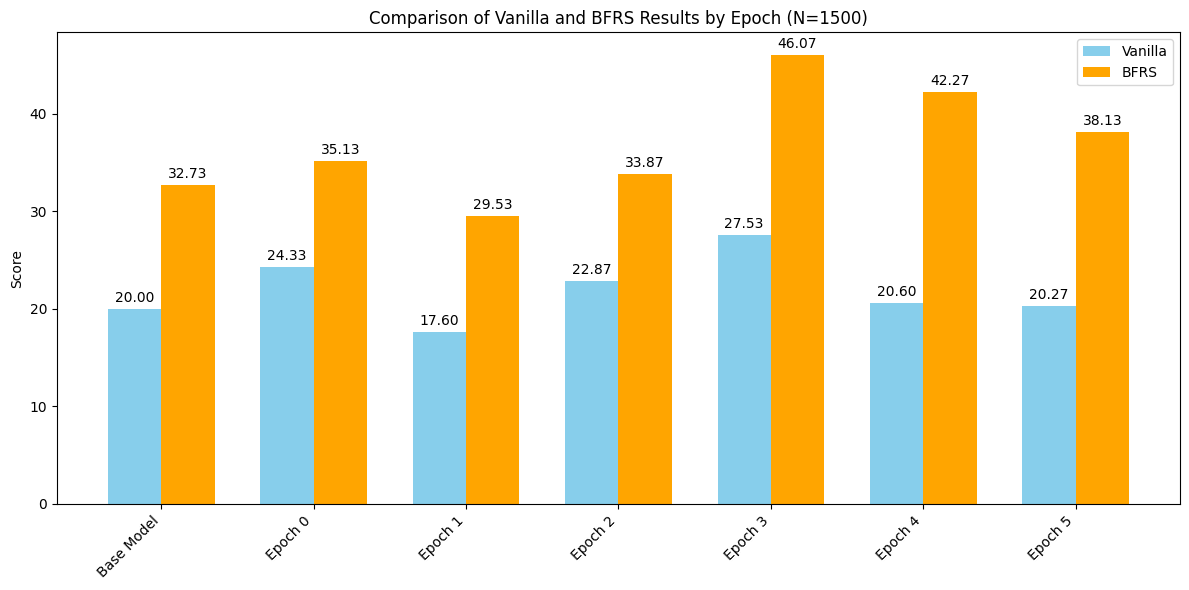

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Process the data
epochs = []
vanilla_scores = []
bfrs_scores = []

for epoch, vanilla_score in ft_vanilla_results_named.items():
    if epoch in ft_bfrs_results_named:
        epochs.append(epoch)
        vanilla_scores.append(vanilla_score)
        bfrs_scores.append(ft_bfrs_results_named[epoch])

# Sort the data by epoch
sorted_data = sorted(zip(epochs, vanilla_scores, bfrs_scores), key=lambda x: x[0])
epochs, vanilla_scores, bfrs_scores = zip(*sorted_data)

# Create the bar chart
x = np.arange(len(epochs))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, vanilla_scores, width, label='Vanilla', color='skyblue')
rects2 = ax.bar(x + width/2, bfrs_scores, width, label='BFRS', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title(f'Comparison of Vanilla and BFRS Results by Epoch (N={len(devset)})')
ax.set_xticks(x)
ax.set_xticklabels(epochs, rotation=45, ha='right')
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [41]:
from dspy.teleprompt import MIPROv2
gpt4o = dspy.LM(model="gpt-4o", **MODEL_PARAMETERS)

COMPILE_PROGRAM = True
current_best = mhqa_finetuned_llamas_8b["epochs-2-total-trained-steps-30"]
with dspy.context(lm=current_best):
    vanilla_program = SimpleIntentClassificationModule()
    if COMPILE_PROGRAM:
        # eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
        teleprompter = MIPROv2(prompt_model=gpt4o, task_model=current_best, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True, num_threads=NUM_THREADS, max_errors=1000)
        compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_trials=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, requires_permission_to_run=False)
        compiled_program.save(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
    else:
        compiled_program = SimpleIntentClassificationModule()
        compiled_program.load(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
    llama_8b_ft_mipro_eval = evaluate_devset(compiled_program)

Beginning MIPROv2 optimization process...

==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
These will be used for as few-shot examples candidates for our program and for creating instructions.

Bootstrapping N=10 sets of demonstrations...
Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


  0%|          | 0/100 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [00:23<00:50,  1.34it/s]


Bootstrapped 3 full traces after 33 examples in round 0.
Bootstrapping set 4/10


 13%|█▎        | 13/100 [00:01<00:10,  8.33it/s]


Bootstrapped 2 full traces after 14 examples in round 0.
Bootstrapping set 5/10


 10%|█         | 10/100 [00:02<00:20,  4.38it/s]


Bootstrapped 1 full traces after 11 examples in round 0.
Bootstrapping set 6/10


 14%|█▍        | 14/100 [00:00<00:05, 14.90it/s]


Bootstrapped 1 full traces after 15 examples in round 0.
Bootstrapping set 7/10


  6%|▌         | 6/100 [00:00<00:14,  6.49it/s]


Bootstrapped 1 full traces after 7 examples in round 0.
Bootstrapping set 8/10


 28%|██▊       | 28/100 [00:04<00:10,  6.75it/s]


Bootstrapped 1 full traces after 29 examples in round 0.
Bootstrapping set 9/10


 21%|██        | 21/100 [00:04<00:17,  4.58it/s]


Bootstrapped 3 full traces after 22 examples in round 0.
Bootstrapping set 10/10


 19%|█▉        | 19/100 [00:02<00:09,  8.90it/s]


Bootstrapped 3 full traces after 20 examples in round 0.

==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
In this step, by default we will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
SOURCE CODE: StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge

Average Metric: 50 / 300  (16.7): 100%|██████████| 300/300 [00:22<00:00, 13.32it/s] 


Default program score: 16.67

==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
In this step, we will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination. Bayesian Optimization will be used for this search process.



/home/ray/anaconda3/lib/python3.9/site-packages/optuna/_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


== Minibatch Trial 1 / 30 ==
Evaluating the following candidate program...

Predictor 0
i: As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
The intent should exactly match one of the following:
['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
p: 

Average Metric: 6 / 25  (24.0): 100%|██████████| 25/25 [00:00<00:00, 1227.67it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1179.17it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 5.0 / 25  (20.0): 100%|██████████| 25/25 [00:02<00:00, 11.86it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9.0 / 25  (36.0): 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 4.0 / 25  (16.0): 100%|██████████| 25/25 [00:01<00:00, 13.27it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1095.40it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 7.0 / 25  (28.0): 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 7.0 / 25  (28.0): 100%|██████████| 25/25 [00:01<00:00, 14.40it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1152.91it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 5 / 25  (20.0): 100%|██████████| 25/25 [00:01<00:00, 12.81it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9.0 / 25  (36.0): 100%|██████████| 25/25 [00:01<00:00, 15.45it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1040.51it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9.0 / 25  (36.0): 100%|██████████| 25/25 [00:01<00:00, 13.84it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 8.0 / 25  (32.0): 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1148.50it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

2024-10-08T00:53:59.910414Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:00.023008Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:01.400189Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:01.868485Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 105.0 / 300  (35.0): 100%|██████

Best full eval score so far! Score: 35.0


== Minibatch Trial 11 / 30 ==
Evaluating the following candidate program...

Predictor 0
i: As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
The intent should exactly match one of the following:
['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'w

Average Metric: 7.0 / 25  (28.0): 100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 10.0 / 25  (40.0): 100%|██████████| 25/25 [00:00<00:00, 643.42it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1060.24it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9.0 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 956.62it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1114.32it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 8.0 / 25  (32.0): 100%|██████████| 25/25 [00:00<00:00, 664.51it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1015.08it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 4 / 25  (16.0): 100%|██████████| 25/25 [00:00<00:00, 1240.23it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1097.99it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 5.0 / 25  (20.0): 100%|██████████| 25/25 [00:00<00:00, 789.26it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1137.59it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 7.0 / 25  (28.0): 100%|██████████| 25/25 [00:00<00:00, 438.27it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:01<00:00, 14.73it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1053.85it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 10.0 / 25  (40.0): 100%|██████████| 25/25 [00:01<00:00, 13.49it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1154.82it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

2024-10-08T00:54:19.931218Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:21.548412Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:21.711081Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:21.849957Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-08T00:54:21.883169Z [error    ] Error fo

Full eval score: 28.0
Best full eval score so far: 35.0


== Minibatch Trial 21 / 30 ==
Evaluating the following candidate program...

Predictor 0
i: As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
The intent should exactly match one of the following:
['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cas

Average Metric: 8.0 / 25  (32.0): 100%|██████████| 25/25 [00:00<00:00, 660.87it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1140.07it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 9.0 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 468.02it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1110.78it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 2 / 25  (8.0): 100%|██████████| 25/25 [00:00<00:00, 1201.94it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1109.90it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:00<00:00, 1230.54it/s]


Full trace of prompts in use on an example...


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 1121.47it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:02<00:00, 12.18it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1110.19it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 12 / 25  (48.0): 100%|██████████| 25/25 [00:01<00:00, 14.45it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1065.90it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1106.97it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 8 / 25  (32.0): 100%|██████████| 25/25 [00:01<00:00, 16.26it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1027.26it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 10 / 25  (40.0): 100%|██████████| 25/25 [00:01<00:00, 14.73it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1052.26it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:01<00:00, 15.62it/s]


Full trace of prompts in use on an example...


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1154.18it/s]






System message:

Your input fields are:
1. `intent` (str): Intent of the query

Your output fields are:
1. `reasoning` (str)
2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## intent ## ]]
{intent}

[[ ## reasoning ## ]]
{reasoning}

[[ ## label ## ]]
{label}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
        The intent should exactly match one of the following:
        ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal

Average Metric: 146.0 / 300  (48.7): 100%|██████████| 300/300 [00:06<00:00, 49.63it/s]


Best full eval score so far! Score: 48.67


[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received',

Average Metric: 495.0 / 1500  (33.0): 100%|██████████| 1500/1500 [01:20<00:00, 18.58it/s]


Lastly, lets give the base 8B model a fair chance by prompt optimizing it.

In [ ]:
# Now we can compare all iterations of this pipeline
print(f"Results for HotPotQA fine-tuning LLaMa 8B with a starting trainset")
print(f"    70B model (vanilla program): {llama_70b_base_eval}")
print(f"    70B model (bfrs program): {llama_70b_bfrs_eval}")
print(f"    8B model (vanilla program): {vanilla_8b_base_eval}")
print(f"    8B model (bfrs program): {llama_8b_bfrs_eval}")
print(f"    8B model (finetuned program): {llama_8b_finetuned_eval}")
print(f"    8B model (finetuned bfrs program): {llama_8b_bfrs_finetuned_eval}")
print(f"    8B model (finetuned mipro program): {llama_8b_ft_mipro_eval}")

TODO: Let's now use the new offline batch inference to evaluate the finetuned model with optimized program on the entire devset

In [ ]:
# TODO: implement once done

In [ ]:
raise NotImplementedError("Stop here")

# Serving

This is the second biggest unknown
I imagine it to be easy, but crazier things have happened

I need to keep a reference or link to the LLM forge job inside the LM.finetune method

how do I get the ray llm image!

We'll start by running the rayllm CLI command below to start the workflow to generate the service yaml configuration:
```bash
mkdir /home/ray/default/deploy/services
cd /home/ray/default/deploy/services
rayllm gen-config 
```

<img src="assets/cli.png" width=500 alt="todo! get this inage of what I need to serve">


## Batch offline inference
- Compare running inference using 
    - Ray Data 
    - multithreading on local VLLM thru HTTP
    - Multithreading to Ray Serve instance thru HTTP
- Dev time estimate: 7 days

<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services